### Načteme data

In [1]:
import numpy as np
import os

PATH = os.path.join("datasets", "07", "imdb")

In [2]:
import pandas as pd

def load_data(file, path=PATH):
    csv = os.path.join(path, file)
    return pd.read_csv(csv)

In [3]:
data = load_data("IMDB Dataset.csv")

### Prozkoumáme a předpřipravíme data

In [4]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
data["label"] = (data["sentiment"] == "positive").astype(int)
data = data.rename(columns={"review":"text"})

In [7]:
data.head()

,text,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


### Rozdělíme dataset na trénovací, testovací a validační

In [8]:
from sklearn.model_selection import train_test_split
train_full, test = train_test_split(data, test_size=0.2, random_state=42)

In [9]:
train, valid = train_test_split(train_full, test_size=0.2, random_state=42)

In [10]:
train.shape

(32000, 3)

In [11]:
valid.shape

(8000, 3)

In [12]:
test.shape

(10000, 3)

### Převod textu na vektor

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [14]:
# Hack pro GPU na Windows
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

Tokenizer převede slova na celočíselné indexy

In [15]:
num_words = 10000
tokenizer = keras.preprocessing.text.Tokenizer(num_words)
tokenizer.fit_on_texts(train["text"])

In [16]:
X_train = tokenizer.texts_to_sequences(train["text"])
X_valid = tokenizer.texts_to_sequences(valid["text"])
X_test = tokenizer.texts_to_sequences(test["text"])

In [17]:
train.iloc[0,0]

"With no fault to the actors (they all put on great performances), the overall story was not very well executed. The movie opens with a great zinger: a crazy old guy forces a young Aborigine girl's car off the road. But then, we're forced to endure 40 minutes of character development with an entirely new group of characters ... and we don't know why until the 40 minutes are up. It turns out that they are the ones who eventually discover the girl's body ... and the story progresses from there.<br /><br />While the story does pick up at that point, it really goes nowhere. After 2 hours, I asked myself: was there a point to this, or was it just to see the characters struggle with accusations of racism and stupidity of how they handled the discovery? The story was ultimately unsatisfying and felt unfinished. While it is well acted, there's not a strong enough backbone in the film to warrant recommending it."

In [18]:
X_train[0]

[17,
 54,
 2171,
 5,
 1,
 149,
 33,
 29,
 264,
 20,
 77,
 366,
 1,
 437,
 62,
 13,
 21,
 51,
 70,
 2207,
 1,
 16,
 2101,
 17,
 3,
 77,
 3,
 1004,
 156,
 222,
 1918,
 3,
 192,
 4131,
 526,
 123,
 1,
 1207,
 18,
 91,
 1041,
 885,
 5,
 4708,
 1904,
 227,
 4,
 108,
 958,
 17,
 32,
 1079,
 168,
 544,
 4,
 102,
 2,
 71,
 89,
 118,
 135,
 363,
 1,
 1904,
 227,
 23,
 53,
 9,
 519,
 42,
 12,
 33,
 23,
 1,
 680,
 36,
 874,
 1827,
 1,
 4131,
 660,
 2,
 1,
 62,
 4331,
 34,
 46,
 7,
 7,
 136,
 1,
 62,
 124,
 1230,
 53,
 30,
 12,
 215,
 9,
 63,
 272,
 1285,
 100,
 228,
 620,
 10,
 1711,
 543,
 13,
 46,
 3,
 215,
 5,
 11,
 38,
 13,
 9,
 39,
 5,
 64,
 1,
 102,
 1650,
 17,
 4,
 2706,
 2,
 2722,
 4,
 86,
 33,
 2365,
 1,
 3415,
 1,
 62,
 13,
 1159,
 6983,
 2,
 443,
 7373,
 136,
 9,
 6,
 70,
 889,
 224,
 21,
 3,
 565,
 190,
 8,
 1,
 19,
 5,
 7062,
 9]

In [19]:
tokenizer.sequences_to_texts([X_train[0]])

["with no fault to the actors they all put on great performances the overall story was not very well executed the movie opens with a great a crazy old guy forces a young girl's car off the road but then we're forced to endure 40 minutes of character development with an entirely new group of characters and we don't know why until the 40 minutes are up it turns out that they are the ones who eventually discover the girl's body and the story progresses from there br br while the story does pick up at that point it really goes nowhere after 2 hours i asked myself was there a point to this or was it just to see the characters struggle with of racism and stupidity of how they handled the discovery the story was ultimately unsatisfying and felt unfinished while it is well acted there's not a strong enough in the film to warrant it"]

Nyní musíme sekvence zarovnat na stejnou délku. Defaultně je padding i truncating 'pre'

In [20]:
maxlen = 500
X_train = keras.preprocessing.sequence.pad_sequences(X_train, padding='post', truncating='post', maxlen=maxlen)
X_valid = keras.preprocessing.sequence.pad_sequences(X_valid, padding='post', truncating='post', maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, padding='post', truncating='post', maxlen=maxlen)

In [21]:
y_train = train["label"]
y_valid = valid["label"]
y_test = test["label"]

In [22]:
X_train.shape

(32000, 500)

### Vytvoření modelu

In [23]:
model = keras.models.Sequential([
    layers.Embedding(num_words, 32, input_length=maxlen, mask_zero=True),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),  
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           320000    
_________________________________________________________________
flatten (Flatten)            (None, 16000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 16000)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                256016    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 576,033
Trainable params: 576,033
Non-trainable params: 0
__________________________________________________

In [25]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0002),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [27]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping])

Epoch 1/100
1000/1000 [==============================] - 8s 7ms/step - loss: 0.6938 - accuracy: 0.5106 - val_loss: 0.6698 - val_accuracy: 0.6478
Epoch 2/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6212 - accuracy: 0.6718 - val_loss: 0.4376 - val_accuracy: 0.8282
Epoch 3/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4105 - accuracy: 0.8333 - val_loss: 0.3224 - val_accuracy: 0.8731
Epoch 4/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3236 - accuracy: 0.8715 - val_loss: 0.2939 - val_accuracy: 0.8792
Epoch 5/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.2763 - accuracy: 0.8955 - val_loss: 0.2809 - val_accuracy: 0.8878
Epoch 6/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.2492 - accuracy: 0.9092 - val_loss: 0.2756 - val_accuracy: 0.8885
Epoch 7/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.2184 - accuracy: 0.9241 - val_loss: 0.2749 - val_ac

### Zobrazíme křivky 

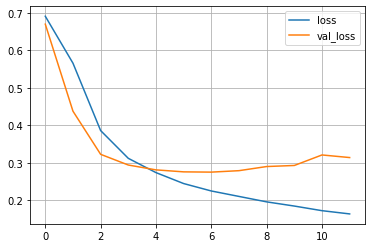

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.grid(True)

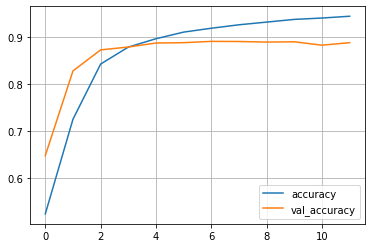

In [29]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.grid(True)

### Vyzkoušíme na testovacích datech

In [30]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2725 - accuracy: 0.8901


[0.2724933624267578, 0.8901000022888184]

### Použití předtrénovaného word embedding

Viz prezentace

Zkusíme řešit situaci, kdy máme velmi málo trénovacích dat

In [31]:
X_train_small = X_train[0:500]
y_train_small = y_train[0:500]

**Varianta bez předtrénovaného embeddingu**

In [32]:
model = keras.models.Sequential([
    layers.Embedding(num_words, 32, input_length=maxlen, mask_zero=True),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),  
])

In [33]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0002),
              loss='binary_crossentropy',
              metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [34]:
history = model.fit(X_train_small,
                    y_train_small,
                    epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping])

Epoch 1/100
16/16 [==============================] - 1s 51ms/step - loss: 0.6941 - accuracy: 0.5006 - val_loss: 0.6933 - val_accuracy: 0.5009
Epoch 2/100
16/16 [==============================] - 1s 42ms/step - loss: 0.6930 - accuracy: 0.5419 - val_loss: 0.6949 - val_accuracy: 0.4918
Epoch 3/100
16/16 [==============================] - 1s 44ms/step - loss: 0.6875 - accuracy: 0.5529 - val_loss: 0.6947 - val_accuracy: 0.4958
Epoch 4/100
16/16 [==============================] - 1s 42ms/step - loss: 0.6799 - accuracy: 0.5760 - val_loss: 0.6983 - val_accuracy: 0.4947
Epoch 5/100
16/16 [==============================] - 1s 42ms/step - loss: 0.6734 - accuracy: 0.6260 - val_loss: 0.6927 - val_accuracy: 0.5178
Epoch 6/100
16/16 [==============================] - 1s 41ms/step - loss: 0.6605 - accuracy: 0.6572 - val_loss: 0.6947 - val_accuracy: 0.4966
Epoch 7/100
16/16 [==============================] - 1s 41ms/step - loss: 0.6604 - accuracy: 0.6578 - val_loss: 0.6945 - val_accuracy: 0.4960
Epoch 

In [35]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.6926 - accuracy: 0.5163


[0.6925994157791138, 0.5163000226020813]

**Varianta s předtrénovaným embeddingem**

pip install tensorflow_hub

In [36]:
import tensorflow_hub as hub

In [37]:
model = keras.models.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),  
])

In [38]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.002),
              loss='binary_crossentropy',
              metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [39]:
history = model.fit(train["text"][0:500],
                    y_train_small,
                    epochs=100,
                    validation_data=(valid["text"], y_valid),
                    callbacks=[early_stopping])

Epoch 1/100
16/16 [==============================] - 2s 86ms/step - loss: 0.7310 - accuracy: 0.5276 - val_loss: 0.6889 - val_accuracy: 0.5113
Epoch 2/100
16/16 [==============================] - 1s 66ms/step - loss: 0.7010 - accuracy: 0.4985 - val_loss: 0.6811 - val_accuracy: 0.5486
Epoch 3/100
16/16 [==============================] - 1s 62ms/step - loss: 0.6677 - accuracy: 0.6212 - val_loss: 0.6737 - val_accuracy: 0.5907
Epoch 4/100
16/16 [==============================] - 1s 58ms/step - loss: 0.6893 - accuracy: 0.5373 - val_loss: 0.6695 - val_accuracy: 0.5746
Epoch 5/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6709 - accuracy: 0.5898 - val_loss: 0.6650 - val_accuracy: 0.6112
Epoch 6/100
16/16 [==============================] - 1s 57ms/step - loss: 0.6659 - accuracy: 0.6001 - val_loss: 0.6628 - val_accuracy: 0.6380
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 0.6700 - accuracy: 0.6166 - val_loss: 0.6589 - val_accuracy: 0.6326
Epoch 

16/16 [==============================] - 1s 60ms/step - loss: 0.5373 - accuracy: 0.7584 - val_loss: 0.5675 - val_accuracy: 0.7153
Epoch 59/100
16/16 [==============================] - 1s 59ms/step - loss: 0.5343 - accuracy: 0.7690 - val_loss: 0.5642 - val_accuracy: 0.7169
Epoch 60/100
16/16 [==============================] - 1s 59ms/step - loss: 0.5118 - accuracy: 0.7591 - val_loss: 0.5645 - val_accuracy: 0.7159
Epoch 61/100
16/16 [==============================] - 1s 59ms/step - loss: 0.5587 - accuracy: 0.7135 - val_loss: 0.5643 - val_accuracy: 0.7153
Epoch 62/100
16/16 [==============================] - 1s 57ms/step - loss: 0.5352 - accuracy: 0.7305 - val_loss: 0.5697 - val_accuracy: 0.7139
Epoch 63/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5125 - accuracy: 0.7520 - val_loss: 0.5613 - val_accuracy: 0.7210
Epoch 64/100
16/16 [==============================] - 1s 58ms/step - loss: 0.5088 - accuracy: 0.7609 - val_loss: 0.5598 - val_accuracy: 0.7225
Epoch 65/100

In [40]:
model.evaluate(test["text"], y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.5599 - accuracy: 0.7206


[0.5599139928817749, 0.7206000089645386]

**Původní varianta s bag-of-words**

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
bow = TfidfVectorizer(max_features=num_words)
X_train_small_bow = bow.fit_transform(train["text"][0:500]).todense()
X_valid_bow = bow.transform(valid["text"]).todense()
X_test_bow = bow.transform(test["text"]).todense()

In [42]:
X_train_small_bow.shape

(500, 10000)

In [43]:
model = keras.models.Sequential([
  layers.Dense(16, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(1, activation='sigmoid'),  
])

In [44]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [45]:
history = model.fit(X_train_small_bow,
                    y_train_small,
                    epochs=100,
                    validation_data=(X_valid_bow, y_valid),
                    callbacks=[early_stopping])

Epoch 1/100
16/16 [==============================] - 1s 49ms/step - loss: 0.6923 - accuracy: 0.5193 - val_loss: 0.6877 - val_accuracy: 0.5123
Epoch 2/100
16/16 [==============================] - 1s 34ms/step - loss: 0.6770 - accuracy: 0.6953 - val_loss: 0.6795 - val_accuracy: 0.6528
Epoch 3/100
16/16 [==============================] - 1s 33ms/step - loss: 0.6582 - accuracy: 0.8202 - val_loss: 0.6720 - val_accuracy: 0.6485
Epoch 4/100
16/16 [==============================] - 1s 34ms/step - loss: 0.6354 - accuracy: 0.8494 - val_loss: 0.6640 - val_accuracy: 0.6839
Epoch 5/100
16/16 [==============================] - 1s 34ms/step - loss: 0.6103 - accuracy: 0.9168 - val_loss: 0.6569 - val_accuracy: 0.6290
Epoch 6/100
16/16 [==============================] - 1s 35ms/step - loss: 0.5984 - accuracy: 0.8726 - val_loss: 0.6474 - val_accuracy: 0.6911
Epoch 7/100
16/16 [==============================] - 1s 35ms/step - loss: 0.5687 - accuracy: 0.8939 - val_loss: 0.6393 - val_accuracy: 0.6836
Epoch 

In [46]:
model.evaluate(X_test_bow, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.4227 - accuracy: 0.8034


[0.42270728945732117, 0.8033999800682068]